In [1]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

In [2]:
def import_metrics_json(models_path, run_num):
    """
    Looks in {models_path}/{run_num}/metrics.json and returns the contents as a
    Python dictionary. Returns None if the path does not exist.
    """
    path = os.path.join(models_path, str(run_num), "metrics.json")
    if not os.path.exists(path):
        return None
    with open(path, "r") as f:
        return json.load(f)

In [3]:
def get_best_metric(models_path, metric_name, reduce_func, compare_func):
    """
    Given the path to a set of runs, determines the run with the best metric value,
    for the given `metric_name`. For each run, the function `reduce_func` must take
    the array of all values for that metric and return a (scalar) value to use for
    comparison. The best metric value is determined by `metric_compare_func`, which
    must take in two arguments, and return whether or not the _first_ one is better.
    Returns the number of the run, the value associated with that run, and a dict of
    all the values used for comparison.
    """
    # Get the metrics, ignoring empty or nonexistent metrics.json files
    metrics = {run_num : import_metrics_json(models_path, run_num) for run_num in os.listdir(models_path)}
    metrics = {key : val for key, val in metrics.items() if val}  # Remove empties
    
    # Get the best value
    best_run, best_val, all_vals = None, None, {}
    for run_num in metrics.keys():
        try:
            val = reduce_func(metrics[run_num][metric_name]["values"])
            all_vals[run_num] = val
            if best_val is None or compare_func(val, best_val):
                best_val, best_run = val, run_num
        except Exception:
            print("Warning: Was not able to compute values for run %s" % run_num)
            continue
    return best_run, best_val, all_vals

In [4]:
def get_best_metric_at_best_epoch(models_path, metric_name, reduce_func, compare_func):
    """
    Given the path to a set of runs, determines the run with the best metric value,
    for the given `metric_name`. For each run, the function `reduce_func` must take
    the array of all values for that metric and return a (scalar) value FOR EACH
    SUBARRAY/VALUE in the value array to use for comparison. The best metric value
    is determined by `metric_compare_func`, which must take in two arguments, and
    return whether or not the _first_ one is better.
    Returns the number of the run, the (one-indexed) number of the epch, the value
    associated with that run and epoch, and a dict of all the values used for
    comparison (mapping pair of run number and epoch number to value).
    """
    # Get the metrics, ignoring empty or nonexistent metrics.json files
    metrics = {run_num : import_metrics_json(models_path, run_num) for run_num in os.listdir(models_path)}
    metrics = {key : val for key, val in metrics.items() if val}  # Remove empties
    
    # Get the best value
    best_run, best_epoch, best_val, all_vals = None, None, None, {}
    for run_num in metrics.keys():
        try:
            # Find the best epoch within that run
            best_epoch_in_run, best_val_in_run = None, None
            for i, subarr in enumerate(metrics[run_num][metric_name]["values"]):
                val = reduce_func(subarr)
                if best_val_in_run is None or compare_func(val, best_val_in_run):
                    best_epoch_in_run, best_val_in_run = i + 1, val
            all_vals[(run_num, best_epoch_in_run)] = best_val_in_run
            
            # If the best value in the best epoch of the run is best so far, update
            if best_val is None or compare_func(best_val_in_run, best_val):
                best_run, best_epoch, best_val = run_num, best_epoch_in_run, best_val_in_run
        except Exception:
            print("Warning: Was not able to compute values for run %s" % run_num)
            continue
    return best_run, best_epoch, best_val, all_vals

In [7]:
def print_validation_profile_and_prior_losses(condition):
    models_path = "/users/amtseng/att_priors/models/trained_models/profile/%s/" % condition
    
    print("Best profile loss overall:")
    best_run, best_epoch, best_val, all_vals = get_best_metric_at_best_epoch(
        models_path,
        "val_prof_corr_losses",
        lambda values: np.mean(values),
        lambda x, y: x < y
    )
    print("\tBest run: %s" % best_run)
    print("\tBest epoch in run: %d" % best_epoch)
    print("\tAssociated value: %s" % best_val)
    
    print("Best epoch in each run:")
    for key in sorted(all_vals.keys(), key=lambda p: int(p[0])):
        print("\tRun %s, epoch %d: %6.2f" % (key[0], key[1], all_vals[key]))
        
    print("All validation profile and prior losses:")
    for key in sorted(all_vals.keys(), key=lambda p: int(p[0])):
        print(key[0])
        metrics = import_metrics_json(models_path, key[0])
        print("\t" + " ".join(["%6.2f" % i for i in np.mean(metrics["train_prof_corr_losses"]["values"], axis=1)]))
        print("\t" + " ".join(["%6.2f" % i for i in np.mean(metrics["val_prof_corr_losses"]["values"], axis=1)]))
        print("\t" + " ".join(["%6.4f" % i for i in np.mean(metrics["val_att_losses"]["values"], axis=1)]))
    return all_vals

In [8]:
noprior_vals = print_validation_profile_and_prior_losses("SPI1")

Best profile loss overall:
	Best run: 8
	Best epoch in run: 10
	Associated value: 85.18974167152687
Best epoch in each run:
	Run 1, epoch 9:  85.39
	Run 2, epoch 7:  85.24
	Run 3, epoch 8:  85.57
	Run 4, epoch 7:  85.59
	Run 5, epoch 10:  85.96
	Run 6, epoch 9:  85.64
	Run 7, epoch 9:  85.54
	Run 8, epoch 10:  85.19
	Run 9, epoch 10:  85.37
	Run 10, epoch 9:  85.65
	Run 11, epoch 9:  85.39
	Run 12, epoch 9:  85.40
	Run 13, epoch 10:  85.97
	Run 14, epoch 10:  85.29
	Run 15, epoch 10:  85.42
All validation profile and prior losses:
1
	 95.14  88.02  86.81  86.35  86.12  85.97  85.87  85.81  85.74  85.68
	 88.08  86.73  86.07  85.85  85.62  85.52  85.54  85.48  85.39  85.43
	0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
2
	 91.23  86.87  86.23  85.94  85.74  85.64  85.57  85.49  85.43  85.40
	 87.47  86.15  85.79  85.47  85.41  85.29  85.24  85.30  85.28  85.33
	0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
3
	 93.98  87.21  86.39  86.06  8

In [9]:
prior_vals = print_validation_profile_and_prior_losses("SPI1_prior")

Best profile loss overall:
	Best run: 3
	Best epoch in run: 10
	Associated value: 85.32390595895272
Best epoch in each run:
	Run 1, epoch 10:  85.80
	Run 2, epoch 9:  85.98
	Run 3, epoch 10:  85.32
	Run 4, epoch 10:  85.70
	Run 5, epoch 10:  86.33
	Run 6, epoch 9:  85.95
	Run 7, epoch 4:  86.53
All validation profile and prior losses:
1
	 92.91  87.50  86.82  86.52  86.33  86.19  86.09  86.04  85.97  85.90
	 87.73  86.90  86.60  86.21  86.21  86.05  86.06  85.83  85.96  85.80
	0.0481 0.0408 0.0387 0.0365 0.0360 0.0349 0.0332 0.0342 0.0329 0.0317
2
	 95.55  87.99  87.04  86.63  86.42  86.28  86.17  86.09  86.06  85.99
	 88.50  87.27  86.65  86.42  86.41  86.08  86.05  86.12  85.98  86.00
	0.0464 0.0417 0.0395 0.0367 0.0369 0.0348 0.0347 0.0336 0.0333 0.0330
3
	 98.92  88.31  87.13  86.66  86.41  86.29  86.19  86.12  86.07  86.02
	 88.38  86.86  86.03  86.08  85.63  85.60  85.55  85.51  85.34  85.32
	0.0477 0.0425 0.0391 0.0368 0.0361 0.0348 0.0339 0.0335 0.0335 0.0331
4
	 97.02  88.45  

In [12]:
def print_validation_and_prior_losses(condition):
    models_path = "/users/amtseng/att_priors/models/trained_models/binary/%s/" % condition
    
    print("Best validation loss overall:")
    best_run, best_epoch, best_val, all_vals = get_best_metric_at_best_epoch(
        models_path,
        "val_corr_losses",
        lambda values: np.mean(values),
        lambda x, y: x < y
    )
    print("\tBest run: %s" % best_run)
    print("\tBest epoch in run: %d" % best_epoch)
    print("\tAssociated value: %s" % best_val)
    
    print("Best epoch in each run:")
    for key in sorted(all_vals.keys(), key=lambda p: int(p[0])):
        print("\tRun %s, epoch %d: %6.3f" % (key[0], key[1], all_vals[key]))
        
    print("All validation profile and prior losses:")
    for key in sorted(all_vals.keys(), key=lambda p: int(p[0])):
        print(key[0])
        metrics = import_metrics_json(models_path, key[0])
        print("\t" + " ".join(["%6.3f" % i for i in np.mean(metrics["train_corr_losses"]["values"], axis=1)]))
        print("\t" + " ".join(["%6.3f" % i for i in np.mean(metrics["val_corr_losses"]["values"], axis=1)]))
        print("\t" + " ".join(["%6.3f" % i for i in np.mean(metrics["val_att_losses"]["values"], axis=1)]))
    return all_vals

In [14]:
noprior_vals = print_validation_and_prior_losses("SPI1")

Best validation loss overall:
	Best run: 12
	Best epoch in run: 2
	Associated value: 0.26864333367058446
Best epoch in each run:
	Run 1, epoch 2:  0.270
	Run 2, epoch 2:  0.277
	Run 3, epoch 2:  0.274
	Run 4, epoch 2:  0.279
	Run 5, epoch 1:  0.281
	Run 6, epoch 2:  0.273
	Run 7, epoch 1:  0.281
	Run 8, epoch 2:  0.278
	Run 9, epoch 2:  0.275
	Run 10, epoch 2:  0.280
	Run 11, epoch 2:  0.270
	Run 12, epoch 2:  0.269
	Run 13, epoch 2:  0.270
	Run 14, epoch 2:  0.275
All validation profile and prior losses:
1
	 0.285  0.236  0.216  0.201  0.190  0.180  0.172  0.167  0.161  0.157
	 0.273  0.270  0.277  0.291  0.305  0.326  0.335  0.355  0.362  0.381
	 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
2
	 0.289  0.240  0.220  0.205  0.194  0.185  0.177  0.171  0.166  0.161
	 0.282  0.277  0.286  0.299  0.316  0.320  0.337  0.348  0.361  0.378
	 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
3
	 0.288  0.240  0.221  0.206  0.196  0.187  0.180  0.174 

In [16]:
prior_vals = print_validation_and_prior_losses("SPI1_prior")

Best validation loss overall:
	Best run: 1
	Best epoch in run: 6
	Associated value: 0.26952209825107726
Best epoch in each run:
	Run 1, epoch 6:  0.270
	Run 2, epoch 3:  0.280
All validation profile and prior losses:
1
	 0.312  0.256  0.253  0.241  0.230  0.221  0.213  0.211  0.205  0.200
	 0.287  0.317  0.279  0.274  0.274  0.270  0.274  0.270  0.278  0.284
	 0.029  0.052  0.036  0.040  0.031  0.030  0.033  0.034  0.032  0.032
2
	 0.330  0.278  0.261
	 0.304  0.287  0.280
	 0.033  0.030  0.028


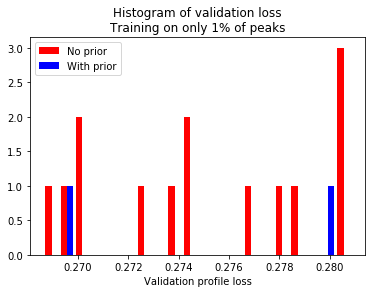

In [17]:
bin_num = 20
plt.figure()
plt.hist(
    [np.array(list(noprior_vals.values())), np.array(list(prior_vals.values()))],
    bin_num, histtype="bar",
    label=["No prior", "With prior"], color=["red", "blue"])
title = "Histogram of validation loss"
title += "\nTraining on only 1% of peaks"
plt.title(title)
plt.xlabel("Validation profile loss")
plt.legend()

In [18]:
np_vals, p_vals = np.array(list(noprior_vals.values())), np.array(list(prior_vals.values()))
t, p = scipy.stats.ttest_ind(np_vals, p_vals)
print(t)
print(p / 2)

0.11280479867322166
0.45589343351802236
